# Лабораторная работа №4 Интерполяция

In [1]:
import numpy as np
import matplotlib.pyplot as plt

В данной лабораторной работе мы будем интерполировать функцию численности населения США по данным за 1910-2020 годы (шаг - 10 лет). Данные взяты с Wikipedia:

In [2]:
data = np.array([92_28_496, 106_021_537, 123_202_624, 132_164_569, 151_325_798, 179_323_175, 203_211_926, 226_545_805, 248_709_873, 281_421_906, 308_745_538, 331_449_281], float)
year = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020], float)

In [3]:
n = len(data)
print("Число узлов: ", n)

Число узлов:  12


## Полезные функции:

In [4]:
epsilon = 0.0001

def is_zero (num):
    if(np.abs(num) < epsilon):
        return 0.0
    else:
        return num
        
def print_matrix(name, A, n, m):
    print("\n", "Matrix", name, "(", n, "x", m, "):")
    
    for i in range(n):
        print("||", end = ' ')
        for j in range(m):
            if(is_zero(A[i][j]) >= 0):
                print(" ", end = '')
            print(format(is_zero(A[i][j]), '5.3f'), end = ' ')
        print("||")
    
    print("\n")
    
    return

def matrix_dot (A, x, n):
    res = np.zeros((n, 1))
    for i in range(n):
        for j in range(n):
            res[i] += A[i][j] * x[j]

    return res

def skalar_dot (a, b, n):
    res = 0.0
    for i in range(n):
        res += a[i] * b[i]

    return res

def vec_norm (v, n):
    res = 0.0
    for i in range(n):
        res = res + v[i] ** 2
    res = res ** (0.5)
    return res


## Интерполяция формой Ньютона:
Форма полинома:
$ N_n(x) = \sum_{k = 0}^{n} b_k \prod_{j = i}^{j + k - 1} (x - x_j) $\
Поиск коэффициентов через разделенные разности:
$ b_1 = \frac{f_{i + 1} - f_i}{x_{i + 1} - x_i}, \quad b_2 = \frac{b_{i + 1} - b_i}{x_{i + 2} - x_i}... $

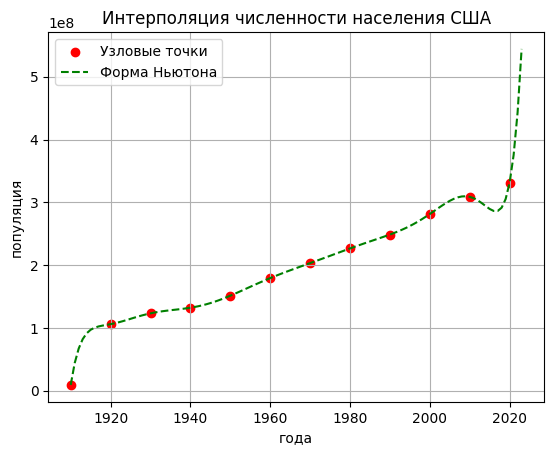

In [5]:
#----------Newton approximation----------#
def Newton_pol (x, year, coeff):
    res = 0.0;
    mul = 1.0;

    for i in range(n):
        for j in range(0, i):
            mul *= (x - year[j])

        res += coeff[i] * mul
        mul = 1.0;

    return res

interval = 2023 - 1910 + 1
temp_coeff = np.zeros((n, n))
coeff = np.zeros(n, dtype = np.float64)

for i in range(n):
    temp_coeff[0][i] = data[i]

for i in range(1, n):
    for j in range(0, n - i):
        temp_coeff[i][j] = (temp_coeff[i - 1][j + 1] - temp_coeff[i - 1][j]) / (year[j + i] - year[j])

#print_matrix("temp_coeff", temp_coeff, n, n)

for j in range(n):
    coeff[j] = temp_coeff[j][0]

population_new = np.zeros(interval, dtype = np.float64)
years_new    = np.zeros(interval, dtype = np.float64)

for i in range(interval):
    years_new[i] = 1910 + i

    population_new[i] = Newton_pol(1910 + i, year, coeff)


plt.scatter(year, data, color='red', label='Узловые точки')
plt.plot(years_new, population_new, label='Форма Ньютона'             , ls = '--', color='green' )
plt.legend()
plt.title('Интерполяция численности населения США')
plt.xlabel('года')
plt.ylabel('популяция')
plt.grid()
plt.show()

## Интерполяция кубическим естественным сплайном:
На каждом промежутке между узловыми точками будем строить полином 3-ей степени с условиями на производные:\
$ S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3 $\
$ S_i(x_{i - 1}) = S_{i - 1}(x_{i - 1}), \:  S'_i(x_{i - 1}) = S'_{i - 1}(x_{i - 1}), \: S^{"}_i(x_{i - 1}) = S^{"}_{i - 1}(x_{i - 1}) $\
$ a_i = f(x_i) $\
$ d_i = \frac{c_i - c_{i - 1}}{3 h_i} $\
$ b_i = \frac{a_i - a_{i - 1}}{h_i} - \frac{2 c_{i - 1} + c_i}{3} \cdot h_i \: \: (h_i = x_i - x_{i - 1}) $\
$ c_{i - 1} h_i + 2 c_i (h_i + h_{i + 1}) + c_{i + 1} h_{i + 1} = 3 \cdot \left( \frac{a_{i + 1} - a_i}{h_{i + 1}} - \frac{a_i - a_{i - 1}}{h_i}\right)$\
При учете $c_0 = c_N = 0$ $c$ находится при помощи метода прогонки для трехдиагональной матрицы.\
В итоге получим гладкую функцию, именуемую кубическим естественным сплайном.

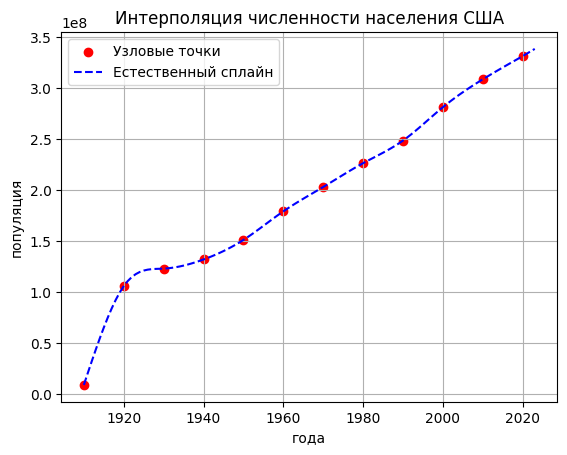

In [6]:
#----------Spline approximation----------#
def natural_cubic_spline(x, y):
    n = len(x) - 1
    h = np.diff(x)
    alpha = np.zeros(n)
    
    # Evalution of alpha
    for i in range(1, n):
        alpha[i] = (3 / h[i]) * (y[i + 1] - y[i]) - (3 / h[i - 1]) * (y[i] - y[i - 1])
    
    # Matrix for system of equations
    l = np.ones(n + 1)
    mu = np.zeros(n)
    z = np.zeros(n + 1)
    
    for i in range(1, n):
        l[i] = 2 * (x[i + 1] - x[i - 1]) - h[i - 1] * mu[i - 1]
        mu[i] = h[i] / l[i]
        z[i] = (alpha[i] - h[i - 1] * z[i - 1]) / l[i]
    
    l[n] = 1
    z[n] = 0
    c = np.zeros(n + 1)
    
    # Running method for c
    for j in range(n - 1, -1, -1):
        c[j] = z[j] - mu[j] * c[j + 1]
    
    b = np.zeros(n)
    d = np.zeros(n)
    
    for i in range(n):
        b[i] = (y[i + 1] - y[i]) / h[i] - h[i] * (c[i + 1] + 2 * c[i]) / 3
        d[i] = (c[i + 1] - c[i]) / (3 * h[i])
    
    return b, c[:-1], d

def Spline_pol(x, y, b, c, d, x_eval):
    n = len(x) - 1
    y_eval = np.zeros_like(x_eval)
    
    for i in range(n):
        mask = (x_eval >= x[i]) & (x_eval <= x[i + 1])
        if np.any(mask):
            dx = x_eval[mask] - x[i]
            y_eval[mask] = y[i] + b[i] * dx + c[i] * dx**2 + d[i] * dx**3
            
        
            
    return y_eval

b, c, d = natural_cubic_spline(year, data)

population_sp = np.zeros(interval, dtype = np.float64)
years_sp    = np.zeros(interval, dtype = np.float64)

for i in range(interval):
    years_sp[i] = 1910 + i

population_sp[0:interval - 4] = Spline_pol(year, data, b, c, d, years_sp[0:interval - 4])

for i in range(interval - 4, interval):
    dx = years_sp[i] - year[n - 1]
    population_sp[i] = data[n - 1] + b[n - 2] * dx + c[n - 2] * dx**2 + d[n - 2] * dx**3


plt.scatter(year, data, color='red', label='Узловые точки')
plt.plot(years_sp , population_sp , label='Естественный сплайн'       , ls = '--', color='blue'  )
plt.legend()
plt.title('Интерполяция численности населения США')
plt.xlabel('года')
plt.ylabel('популяция')
plt.grid()
plt.show()

## Интерполяция методом наименьших квадратов:
Пусть $\varphi_i $ - базис функций для интерполяции зависимости. Тогда интерполянт будет выглядеть следующим образом: $P_n = \sum_{k = 0}^{n} a_k \varphi_k(x)$.
Метод наименьших квадратов (МНК) заключается в минимизации выражения:\
$ \sum_{k = 0}^{n} (P_n(x_i) - y_i(x_i))^2 = S(a_0,.. a_n) \rightarrow min \implies 
  \frac{\partial S}{\partial a_i} = 0 \qquad \forall i \in [0, n] $\
Отсюда получим СЛАУ, которую можем решить одним из методов из лабораторной работы №2:\
$ A \cdot b = f $\
$ A_{m, n} = \left(
\begin{matrix}
        (\varphi_0, \varphi_0) & (\varphi_0, \varphi_1) & \cdots & (\varphi_0, \varphi_n)
        \\
        \vdots  & \vdots  & \ddots & \vdots 
        \\
         (\varphi_n, \varphi_0) & (\varphi_n, \varphi_1) & \cdots & (\varphi_n, \varphi_n)
  \end{matrix} \right)$
$
b = (a_0 \cdots a_n)^T \qquad f = ((y, \varphi_0) \cdots (y, \varphi_n))^T
$\
$ (\varphi_i, \varphi_j) = \sum_{k = 0}^{n} \varphi_i(x_k) \varphi_j(x_k) \qquad
  (y, \varphi_j) = \sum_{k = 0}^{n} y(x_k) \varphi_j(x_k)$


 Matrix x_gauss ( 12 x 1 ):
||  19388365440514.707 ||
|| -6199502425.821 ||
|| -20010524.319 ||
||  5796.874 ||
||  5.624 ||
||  0.000 ||
||  0.000 ||
||  0.000 ||
||  0.000 ||
||  0.000 ||
||  0.000 ||
||  0.000 ||




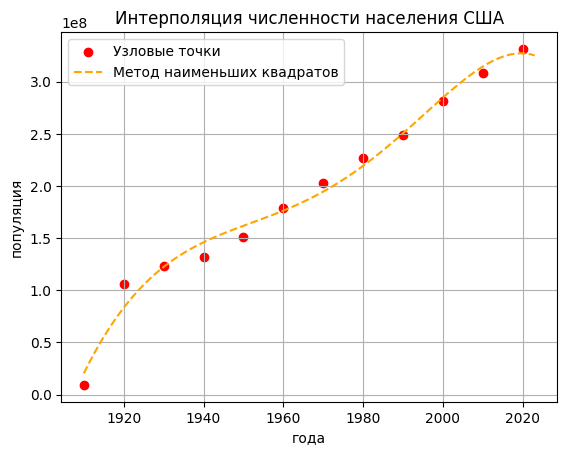

Достоверность аппроксимации МНК: 0.9881257835882822


In [7]:
def matrix_el (x, i, j):
    n = len(x)
    res = 0.0

    for k in range(n):
        res += x[k]**(i + j)

    return res

#---------- Method of least squares ----------#
def MLS_method (x, y):
    n = len(x)
    
    M_phi = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            M_phi[i][j] = matrix_el(x, i, j)

    y_vec = np.zeros((n, 1))
    for i in range(n):
        for j in range(n):
            y_vec[i] += y[j] * (x[j]**i)

    A = M_phi
    b = y_vec 

    #---------- Gauss method ----------#
    x_inter = np.zeros(n)
    matrix  = np.zeros((n, n + 1))

    for i in range(n):
        for j in range(n):
            matrix[i][j] = A[i][j]
        matrix[i][n] = b[i]

    for i in range(n):
        max_row = i + np.argmax(np.abs(matrix[i:, i]))
        matrix[[i, max_row]] = matrix[[max_row, i]]

        for j in range(i + 1, n):
            factor = matrix[j][i] / matrix[i][i]
            matrix[j] = matrix[j] - factor * matrix[i]

    for i in range(n - 1, -1, -1):
        x_inter[i] = (matrix[i][-1] - np.dot(matrix[i][i + 1:n], x_inter[i + 1:n])) / matrix[i][i]

    x_gauss = np.zeros((n, 1))

    for i in range(n):
        x_gauss[i] = x_inter[i]

    print_matrix("x_gauss", x_gauss, n, 1)
    #----------- Gauss end ----------#

    return x_gauss
#---------- MLS end ----------#

coeff = np.zeros((n, 1))
coeff = MLS_method(year, data)

population_ls = np.zeros(interval, dtype = np.float64)
years_ls    = np.zeros(interval, dtype = np.float64)

for i in range(interval):
    years_ls[i] = 1910 + i

for i in range(interval):
    for j in range(n):
        population_ls[i] += coeff[j] * (years_ls[i]**j)


y_mid = 0.0
for i in range(n):
    y_mid += data[i]
y_mid /= n

R2 = 0.0
den = 0.0
num = 0.0
for i in range(n):
    num += (data[i] - population_ls[i * 10])**2
    den += (data[i] - y_mid)**2
R2 = 1 - (num / den)

plt.scatter(year, data, color='red', label='Узловые точки')
plt.plot(years_ls , population_ls , label='Метод наименьших квадратов', ls = '--', color='orange')
plt.legend()
plt.title('Интерполяция численности населения США')
plt.xlabel('года')
plt.ylabel('популяция')
plt.grid()
plt.show()

print("Достоверность аппроксимации МНК:", R2)
    
    

## Графики интерполянтов и прогнозы:

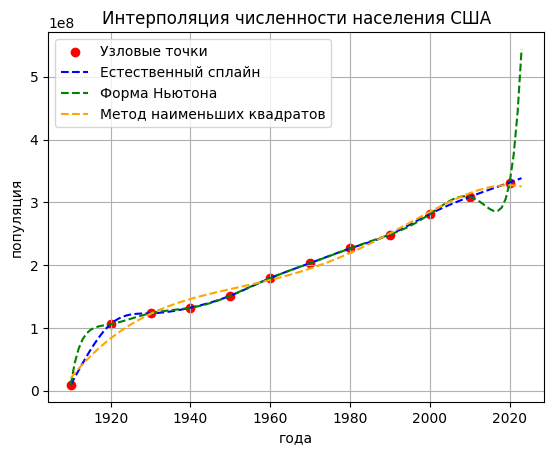

Прогнозы на 2023 год: 544266485 (Ньютон), 338489109 (сплайн), 325186717 (МНК).
По одной из публикаций: 339900000


In [8]:
plt.scatter(year, data, color='red', label='Узловые точки')
plt.plot(years_sp , population_sp , label='Естественный сплайн'       , ls = '--', color='blue'  )
plt.plot(years_new, population_new, label='Форма Ньютона'             , ls = '--', color='green' )
plt.plot(years_ls , population_ls , label='Метод наименьших квадратов', ls = '--', color='orange')
plt.legend()
plt.title('Интерполяция численности населения США')
plt.xlabel('года')
plt.ylabel('популяция')
plt.grid()
plt.show()

print("Прогнозы на 2023 год:", int(population_new[interval - 1]), "(Ньютон),", int(population_sp[interval - 1]), "(сплайн),", int(population_ls[interval - 1]), "(МНК).")
print("По одной из публикаций:", 339900000)

## Выводы
В данной лабораторной работе мы познакомились с базовыми методами интерполяции зависимостей по имеющемуся набору точек. Были рассмотрены форма Ньютона, кубический естественный сплайн и метод наименьших квадратов. По полученным интерполянтам были сделаны прогнозы о численности населения США на 2023 год, видно, что наиболее близкий результат к реальности дал сплайн. Форма Ньютона имеет существенный недостаток при увеличении степени полинома: точность аппроксимации падает на концах интерполируемого отрезка, что мы и можеи наблюдать на графике (резкий скачок вверх). МНК тоже дал хороший результат, поскольку его достоверность аппроксимации близка к единице: $ R^2 = 0.98812 $. Этот метод, однако, не учитывает условие интерполяции, поэтому полученная функция не обязана проходить через узловые точки.